In [1]:
import sys
print(sys.executable) 

/Library/Frameworks/Python.framework/Versions/3.11/bin/python3.11


In [62]:
# from ucimlrepo import fetch_ucirepo 
  
# # fetch dataset 
# mushroom = fetch_ucirepo(id=73) 
  
# # data (as pandas dataframes) 
# X = mushroom.data.features 
# y = mushroom.data.targets 
  
# # metadata 
# print(mushroom.metadata) 
  
# # variable information 
# print(mushroom.variables) 


In [246]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import arff
import time

### **Step 1**: Importing mushroom csv data into a dataframe 
(source: https://archive.ics.uci.edu/dataset/73/mushroom)

In [108]:
# Dataset source: https://archive.ics.uci.edu/dataset/73/mushroom
dfm = pd.read_csv('mushroom_data.csv')
print(dfm.info())

dfm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


### **Step 2**: Data Cleaning
Data set is relatively clean, but there's a few notable steps still.
1. The stalk-root column has some missing data, so filter out rows with empty cells first.
2. When checking the heatmap, I noticed that only 1 value in the veil-type column is actually present after cleaning up the stalk-root column, so I got rid of the feature.
3. Converted the poisonous column (the test set) from an object type to int (0/1 for binary classification).

In [116]:
#stalk-root column has some missing data, remove those rows
dfm = dfm.dropna(subset=['stalk-root'])
print("Number of rows: " + str(dfm.shape[0]))

# Every row after removing invalid stalk-roots has the same veil-type, so column is redundant
# dfv = dfm.loc[dfm['veil-type'] == 'u']
# print(dfv.shape[0]) #length equals 0
dfm = dfm.drop(['veil-type'], axis=1)

# Convert poisonous from string to integer for easier modeling (0 = edible, 1 = poisonous)
# Not sure if actually needed
if 'poisonous' in dfm:
    dfm['poisonous_n'] = dfm.poisonous.apply(lambda x: 0 if x == 'e' else 1)
    dfm = dfm.drop(['poisonous'], axis=1)

# Works, but throws a warning due to changing column type from string to int
# dfm['poisonous'] = dfm['poisonous'].replace('e', 0)
# dfm['poisonous'] = dfm['poisonous'].replace('p', 1)

dfm.info()

Number of rows: 5644
<class 'pandas.core.frame.DataFrame'>
Index: 5644 entries, 0 to 8114
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 5644 non-null   object
 1   cap-surface               5644 non-null   object
 2   cap-color                 5644 non-null   object
 3   bruises                   5644 non-null   object
 4   odor                      5644 non-null   object
 5   gill-attachment           5644 non-null   object
 6   gill-spacing              5644 non-null   object
 7   gill-size                 5644 non-null   object
 8   gill-color                5644 non-null   object
 9   stalk-shape               5644 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  5644 non-null   object
 12  stalk-surface-below-ring  5644 non-null   object
 13  stalk-color-above-ring    5644 non-null   object
 14  stalk-co

### **Step 3**: Checking for correlated features
Started by plotting the correlation matrix. Values need to be normalized into ints first since all the features are categorical/objects.

In [120]:
# Correlation matrix, Factorizing due to non-numerical data types
dfm_cor = dfm.apply(lambda x: x.factorize()[0]).corr()
dfm_cor

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous_n
cap-shape,1.000000,0.061266,0.006390,0.024314,0.031966,0.036518,0.012686,0.045297,0.060692,0.079150,...,0.066042,0.081847,0.094223,0.047866,0.071161,0.076913,0.103736,0.128877,0.030009,-0.012738
cap-surface,0.061266,1.000000,-0.018024,0.170464,0.231799,-0.011919,-0.079934,0.079547,0.078234,0.052305,...,0.184989,0.311082,0.294905,-0.007939,-0.098754,0.204256,0.001669,0.387680,0.328787,0.068231
cap-color,0.006390,-0.018024,1.000000,-0.037622,0.289324,0.057650,-0.058742,0.031560,0.141792,0.116227,...,-0.073184,0.019587,0.042405,-0.026314,0.158058,-0.041243,0.166598,0.099936,0.085354,-0.121709
bruises,0.024314,0.170464,-0.037622,1.000000,0.559444,0.064351,0.439183,-0.040178,-0.036862,-0.348294,...,0.643622,0.416310,0.382574,0.042863,0.007218,0.830229,0.409097,0.007056,-0.061334,-0.435562
odor,0.031966,0.231799,0.289324,0.559444,1.000000,0.151638,0.011745,0.261129,0.264612,0.028335,...,0.454124,0.502011,0.451342,-0.000648,0.158408,0.530517,0.492609,0.353483,0.280530,-0.415438
gill-attachment,0.036518,-0.011919,0.057650,0.064351,0.151638,1.000000,-0.026630,0.021353,0.095599,-0.057738,...,0.050650,0.163367,0.164673,-0.002131,0.520652,0.157052,0.150416,0.093391,0.036296,-0.071945
gill-spacing,0.012686,-0.079934,-0.058742,0.439183,0.011745,-0.026630,1.000000,-0.178484,-0.148132,0.314060,...,-0.173242,-0.342702,-0.264082,0.080026,-0.074985,0.099214,-0.175159,-0.378184,-0.228317,0.264160
gill-size,0.045297,0.079547,0.031560,-0.040178,0.261129,0.021353,-0.178484,1.000000,0.115416,0.282368,...,0.246351,0.268924,0.182452,-0.099801,0.060127,0.240390,0.093165,0.105979,0.109261,0.215289
gill-color,0.060692,0.078234,0.141792,-0.036862,0.264612,0.095599,-0.148132,0.115416,1.000000,0.088911,...,0.093794,0.197613,0.202523,0.063676,0.167014,0.065731,0.221718,0.257183,0.212575,-0.129357
stalk-shape,0.079150,0.052305,0.116227,-0.348294,0.028335,-0.057738,0.314060,0.282368,0.088911,1.000000,...,-0.563249,-0.330838,-0.300655,-0.038458,-0.162582,-0.426768,-0.448541,0.031050,-0.000168,0.592446


##### Plotting out the heatmap, for easier readability.

<Axes: >

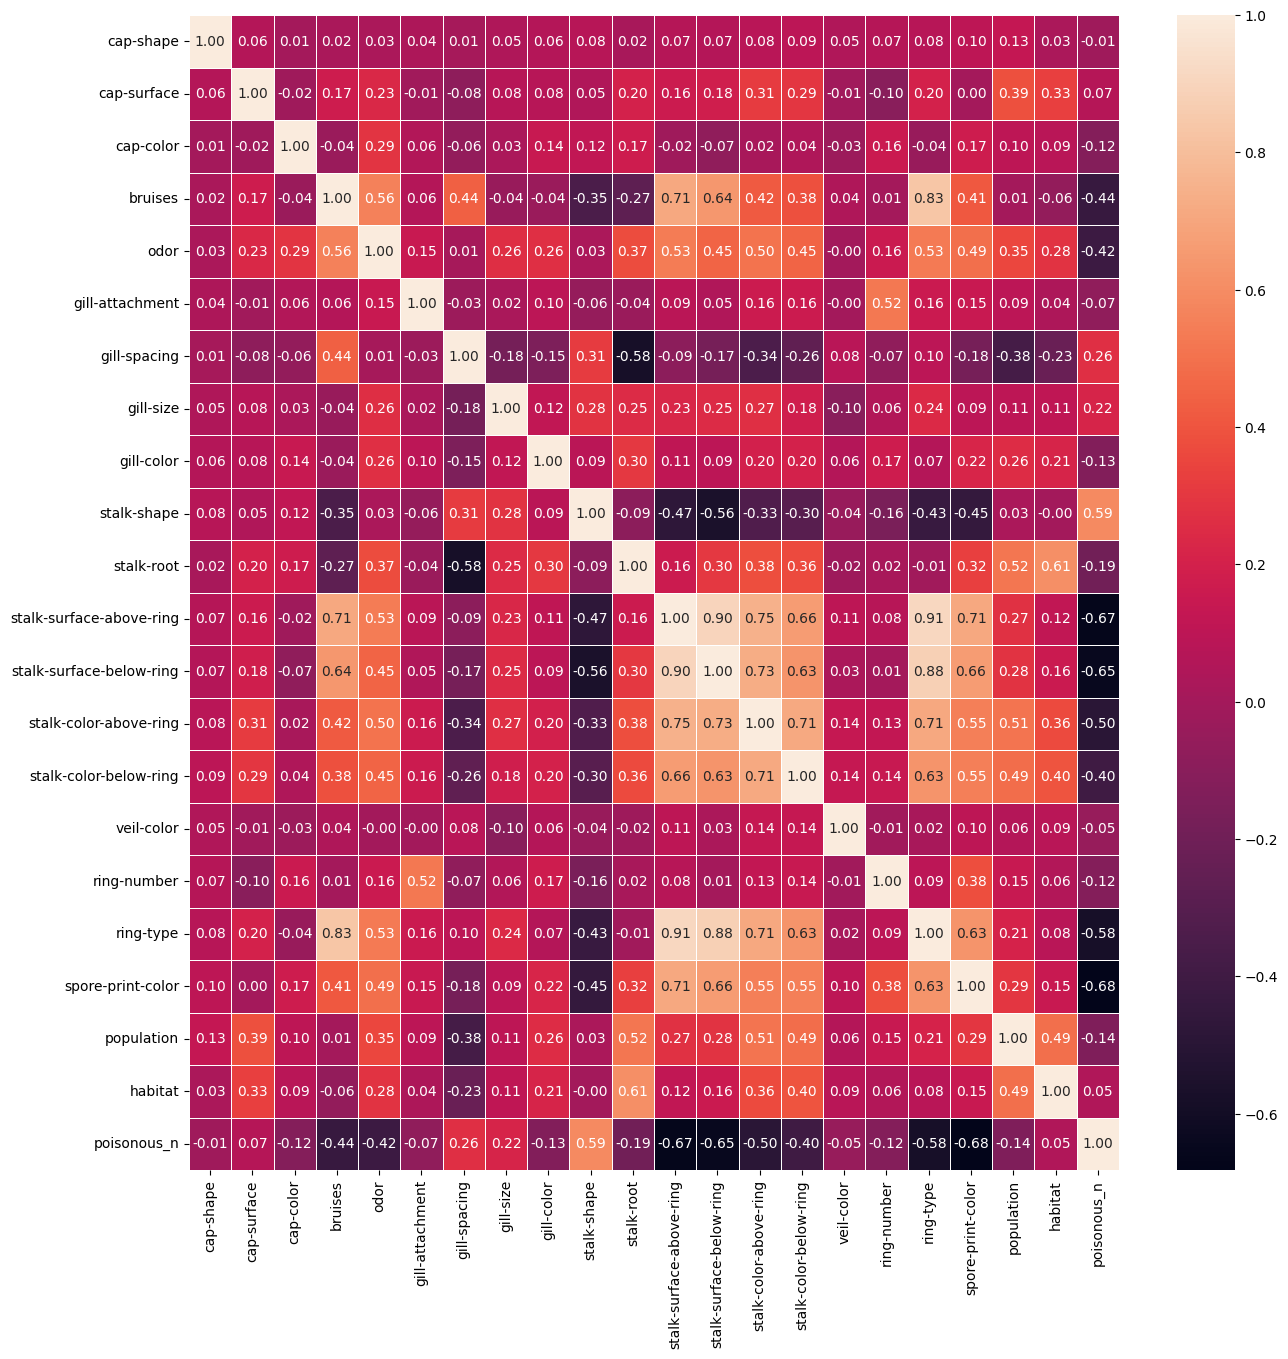

In [119]:
#Heatmap
plt.figure(figsize=(15,15))
sns.heatmap(dfm_cor, linewidths=.5, annot=True, fmt=".2f")

# Not too many correlations, notable ones:
# The stalk-related columns are correlated, also correlated with ring-type
# Possible correlation between ring-type and bruises as well

# Not much individual correlation with poisonous, closest is stalk-shape

##### Pairplot doesn't really show much, probably not too useful for categorical features honestly.

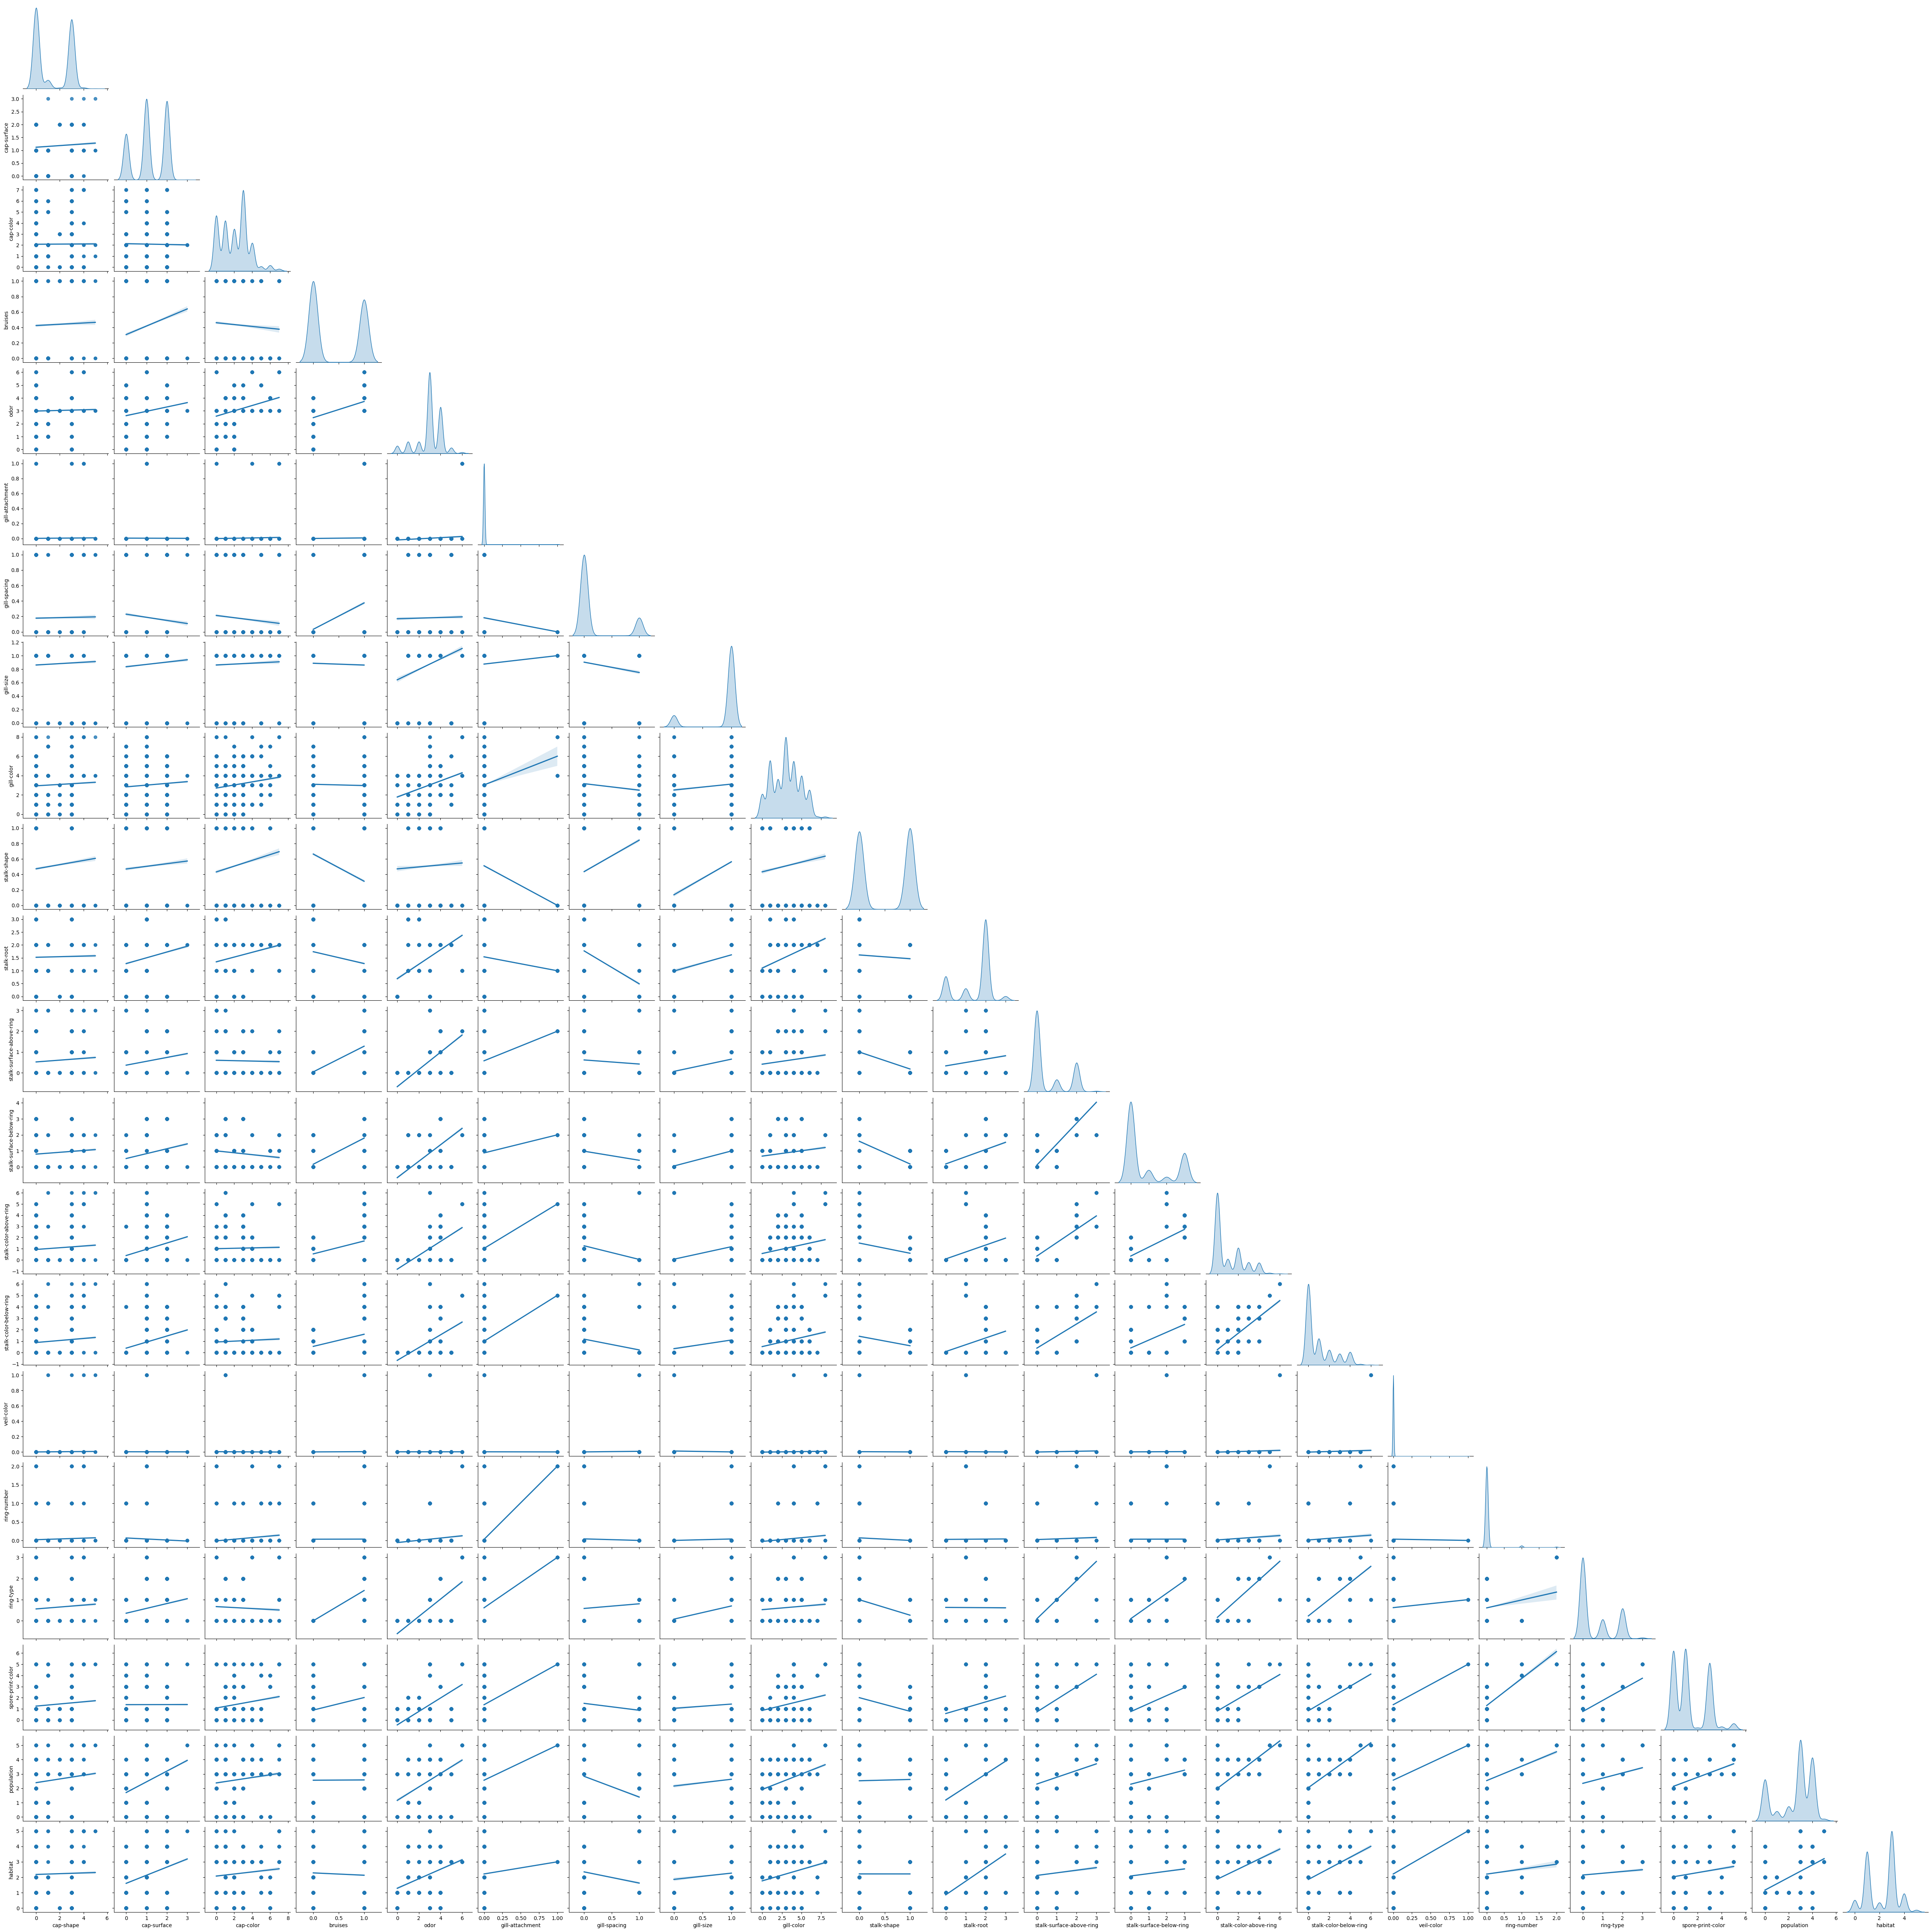

In [125]:
#Pairplot
sns.pairplot(dfm.apply(lambda x: x.factorize()[0]), vars = dfm.columns[0:21], kind='reg', diag_kind='kde', corner=True, dropna=True)

##### **Quick Conclusions**:
There's not too much correlation between features, but there's a few notable ones still.
1. The stalk related columns (stalk-color and stalk-surface) are somewhat correlated unsurprisingly, along with the ring-type feature.
2. Bruises and ring-type also might have some correlation.
3. The poisonous column doesn't have any strong correlations with any one feature, so whatever model is used will need to use multiple features.

### **Step 4**: Data splitting
Total row count is 5644 rows, which is relatively large, I can use a large percentage for training still. Starting with 80:20 train/test split.

In [213]:
# Testing out different models
# Binary Classification problem, so potential models: Logisic Regression, Decision Trees (single, RF), SVM

# Splitting the data
# All categorical features
# 5644 total samples, need to figure out how to split
X = dfm.apply(lambda x: x.factorize()[0]).iloc[:, 0:-1]
y = dfm.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

print("Training set size: " + str(len(X_train)))
print("Test set size: " + str(len(X_test)))

# print(X_train)
# print(y_train)

Training set size: 4515
Test set size: 1129


### **Step 5**: Modeling
This is a binary classification problem (a mushroom is either edible (0) or poisonous (1)). So potential models I'll test out include: Logistic Regression, Decision Trees (Single DT, Random Forest, Bagging, Gradient), kNN, and SVMs

In [197]:
# Storing accuracy scores of models for comparison
scores = {}

In [ ]:
# Storing model scores for comparison later
scores = {}

#### **A. Logistic Regression**

In [252]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

start = time.time()
LogReg = LogisticRegression(solver='liblinear').fit(X_train, y_train)
stop = time.time()

print(log_reg.coef_)
scores['LR'] = log_reg.score(X_test, y_test)

print("Train Score: " + str(log_reg.score(X_train, y_train)))
print("Test Score: " + str(scores['LR']))
print("Training Time: " + str(stop - start) + "s")

[[-3.61038334e-02 -1.22816517e+00  3.35763980e-01 -7.48072988e+00
   2.20801704e+00 -4.33608905e-04 -1.65167186e+00 -9.21593091e+00
   2.32130118e-01 -3.49767284e+00  3.18633891e-01  2.53455298e+00
   5.86466998e-01  1.36814489e+00 -1.54460136e+00  2.38858303e-03
  -5.60648321e-02  4.54825058e+00  5.61569795e-01 -3.95922597e-01
  -1.21531926e+00]]
Train Score: 0.9906976744186047
Test Score: 0.9867139061116031
Training Time: 0.02803206443786621s


Predicting on the test set and seeing the confusion matrix:

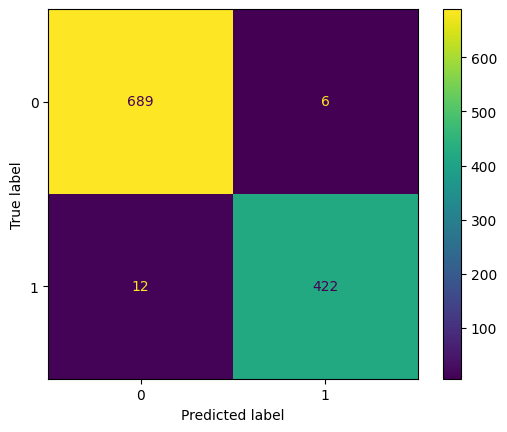

In [190]:
y_test_pred = LogReg.predict(X_test)

lr_cm = confusion_matrix(y_test, y_test_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm)
cm_disp.plot()
plt.show()

##### Plotting the ROC curve:

Text(0.7, 0.2, 'AUC=0.999')

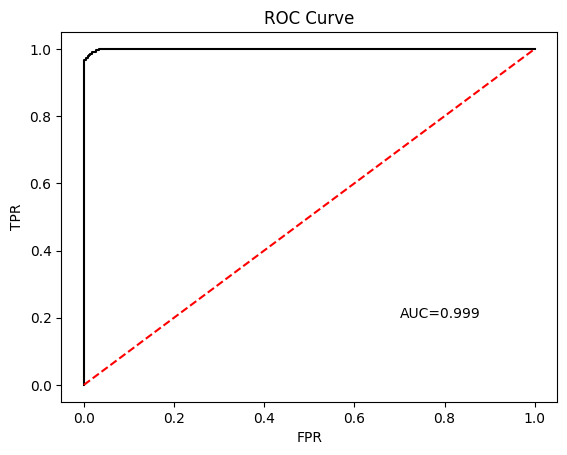

In [191]:
# Probabilities
y_test_pred_p = LogReg.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_test_pred_p[:, 1])
auc_score = roc_auc_score(y_test, y_test_pred_p[:, 1])

# print(fpr)
# print(tpr)

plt.plot(fpr, tpr, 'k-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'r--')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7, 0.2, 'AUC='+"{:.3f}".format(auc_score))

#### Logistic Regression Conclusions:
This model seems to perform incredibly strong, with a very low error rate. After testing with multiple versions of data splitting (by changing the random_state parameter in train_test_split), the area under the ROC curve was consistently almost 1, and the accuracy is usually above .98.

### B. k-Nearest Neighbors

In [229]:
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier(n_neighbors=7, algorithm='auto').fit(X_train, y_train)

scores['kNN'] = kNN.score(X_test, y_test)

print("Train Score: " + str(kNN.score(X_train, y_train)))
print("Test Score: " + str(scores['kNN']))

Train Score: 1.0
Test Score: 1.0


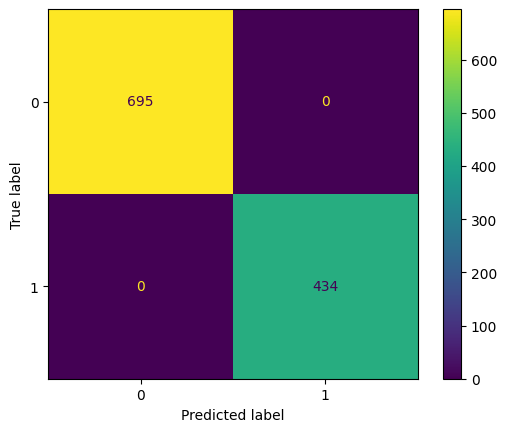

In [230]:
# Confusion Matrix
y_knn_test_pred = kNN.predict(X_test)

knn_cm = confusion_matrix(y_test, y_knn_test_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm)
cm_disp.plot()
plt.show()

#### kNN Conclusions
Apparently, kNN is basically perfect with this data set. It starts making errors when k is set too high (k > 9, higher k = more errors), but until that point, it had a 100% accuracy after trying multiple different random train/test splits. Setting it at k=7 since after that's where accuracy starts to drop, so it's probably the most balanced between bias/variance.

Logically, this makes some sense given how evolution works; related species of mushrooms will have similar characteristics, including whether they're toxic, so classifying them based on the most similar mushrooms makes some sense. Still kind of surprising though, it could indicate an issue with the dataset if the mushrooms they sampled aren't varied enough/overly biased.

### C. Decision Trees

Starting with a single decision tree:

Train Score: 1.0
Test Score: 1.0


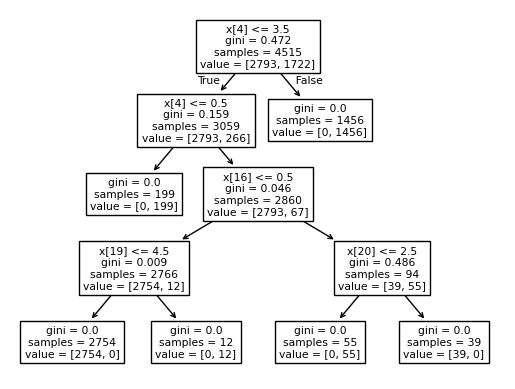

In [238]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Single Decision Tree
sdt_clf = DecisionTreeClassifier(criterion='gini').fit(X_train, y_train)
plot_tree(sdt_clf)


scores['SDT'] = sdt_clf.score(X_test, y_test)
print("Train Score: " + str(sdt_clf.score(X_train, y_train)))
print("Test Score: " + str(scores['SDT']))

Trying Random Forest:

In [242]:
# Random Forest

Trying Gradient Boosting Machines:

In [243]:
# GBM

#### Decision Tree Conclusions:

### D. SVM

In [244]:
# SVM

#### SVM Conclusions:

### **Step 6**: Model Comparisons

In [ ]:
# Go through scores and compare